## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [56]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
# ks = [1]#list(range(11))
# step_sizes = [2**k for k in ks]
step_sizes = [4, 8, 16]#[4,  8, 216]
letter = 'a'
noise = 0.1

### load data & models

In [75]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
perfect_data  = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(0.0)))
# train_data = np.load(os.path.join(data_dir, 'train_noise0.0.npy'))
# train_data = np.load(os.path.join(data_dir, 'train_long_noise0.0.npy'))
# train_data = np.load(os.path.join(data_dir, 'train_long_noise0.0.npy'))
# test_data = train_data[:10]
# val_data = train_data

In [58]:
# load models
models = list()
for step_size in step_sizes:
#     try:
#     print('load model_D{}.pt'.format(step_size))
    model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
    print("load ", model_name)
#     original_model_D1_noise0.0
    try:
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        try:
            model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
            models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
        except:
            model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, 'b')
            models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#     except:
#         print("problem")
#         pass

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load  original_model_D4_noise0.1.pt
load  original_model_D8_noise0.1.pt
load  original_model_D16_noise0.1.pt


In [59]:
print(len(models))

3


### benchmarks

In [60]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

In [61]:
 def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        cur_step = self.step_size - 1
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next

        # include the initial frame
        steps.insert(0, 0)
        print(x_init[0])
        preds.insert(0, torch.tensor(x_init).float().to(self.device))
        
        print(preds[0][0])

        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()
        print(y_preds[0,0])

        return y_preds

In [62]:
# y_preds = uni_scale_forecast(models[0], torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)

In [63]:
# plt.plot(test_data[0,1:,0])
# plt.plot(test_data[0,1:,1])
# plt.plot(y_preds[0,:,0])
# plt.plot(y_preds[0,:,1])
# # plt.ylim([-3,3])
# # plt.show()



  0%|          | 0/3 [00:00<?, ?it/s]

/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


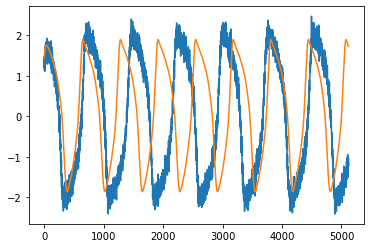

/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


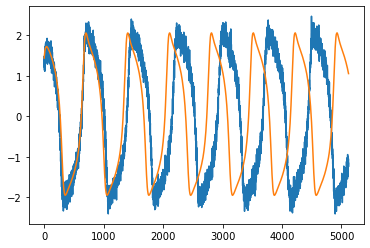

/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


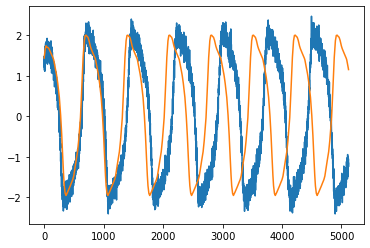

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

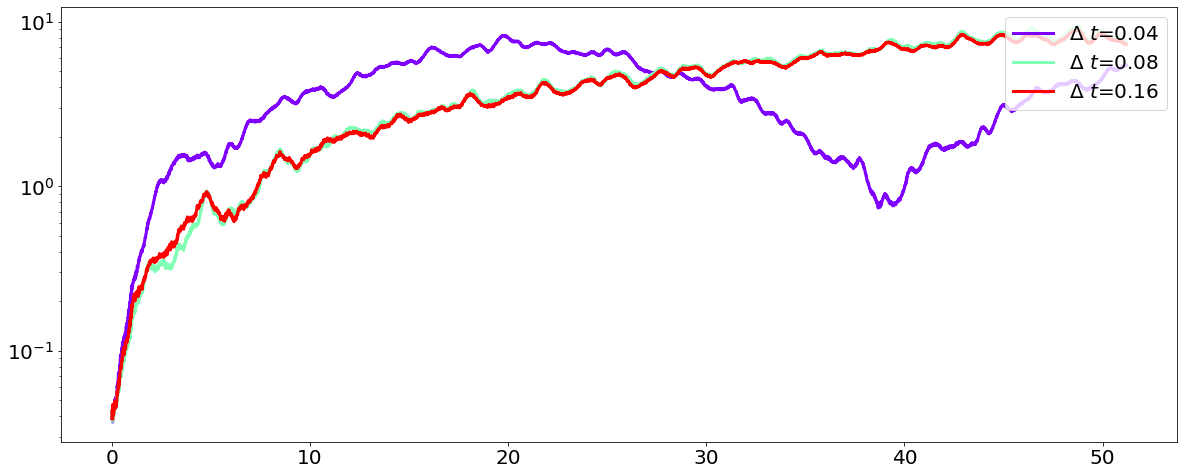

In [64]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
    plt.plot(test_data[0, 1:, 0])
    plt.plot(y_preds[0,:,0])
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [65]:
# fig = plt.figure(figsize=(20, 8))
# colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).detach().numpy()
#     rgb = next(colors)
#     plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
# # plt.xlim([0,100])
# plt.ylim([0.0001, 10])
# plt.title("Hyperbolic with different time steps")
# plt.legend(fontsize=20, loc='upper right')
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

In [66]:
def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size + 1
    print("models[0].step_size = ", models[0].step_size)
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)
    print("preds shape = ", preds.shape)

    # vectorized simulation
    indices.append(0)
    preds[:, 0, :] = x_init
    total_step_sizes = n_steps
    for model in models:
        print("model.step_size = ", model.step_size)
        n_forward = int(total_step_sizes/model.step_size)
        y_prev = preds[:, indices, :].reshape(-1, n_dim)
        indices_lists = [indices]
        for t in range(n_forward):
            y_next = model(y_prev)
#             print("y_next shape = ", y_next.shape)
            shifted_indices = np.array([x + (t + 1) * model.step_size for x in indices])
#             print("extended_n_steps =", extended_n_steps)
#             print("indices = ", indices)
#             print("shifted_indices", shifted_indices)
            shifted_indices = shifted_indices[np.array(shifted_indices) < extended_n_steps]  
            
            indices_lists.append(shifted_indices)
#             
#             print("y_next.reshape(n_test, -1, n_dim) shape = ", y_next.reshape(n_test, -1, n_dim).shape)
#             print("preds[:, shifted_indices, :] shape = ", preds[:, shifted_indices, :].shape)
            preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)[:, :len(shifted_indices)]
            
            y_prev = y_next
        indices = [val for tup in zip(*indices_lists) for val in tup]
        total_step_sizes = model.step_size - 1

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds

models[0].step_size =  16
preds shape =  torch.Size([320, 5138, 2])
model.step_size =  16
model.step_size =  8
model.step_size =  4
0
1
2


(0.001, 10)

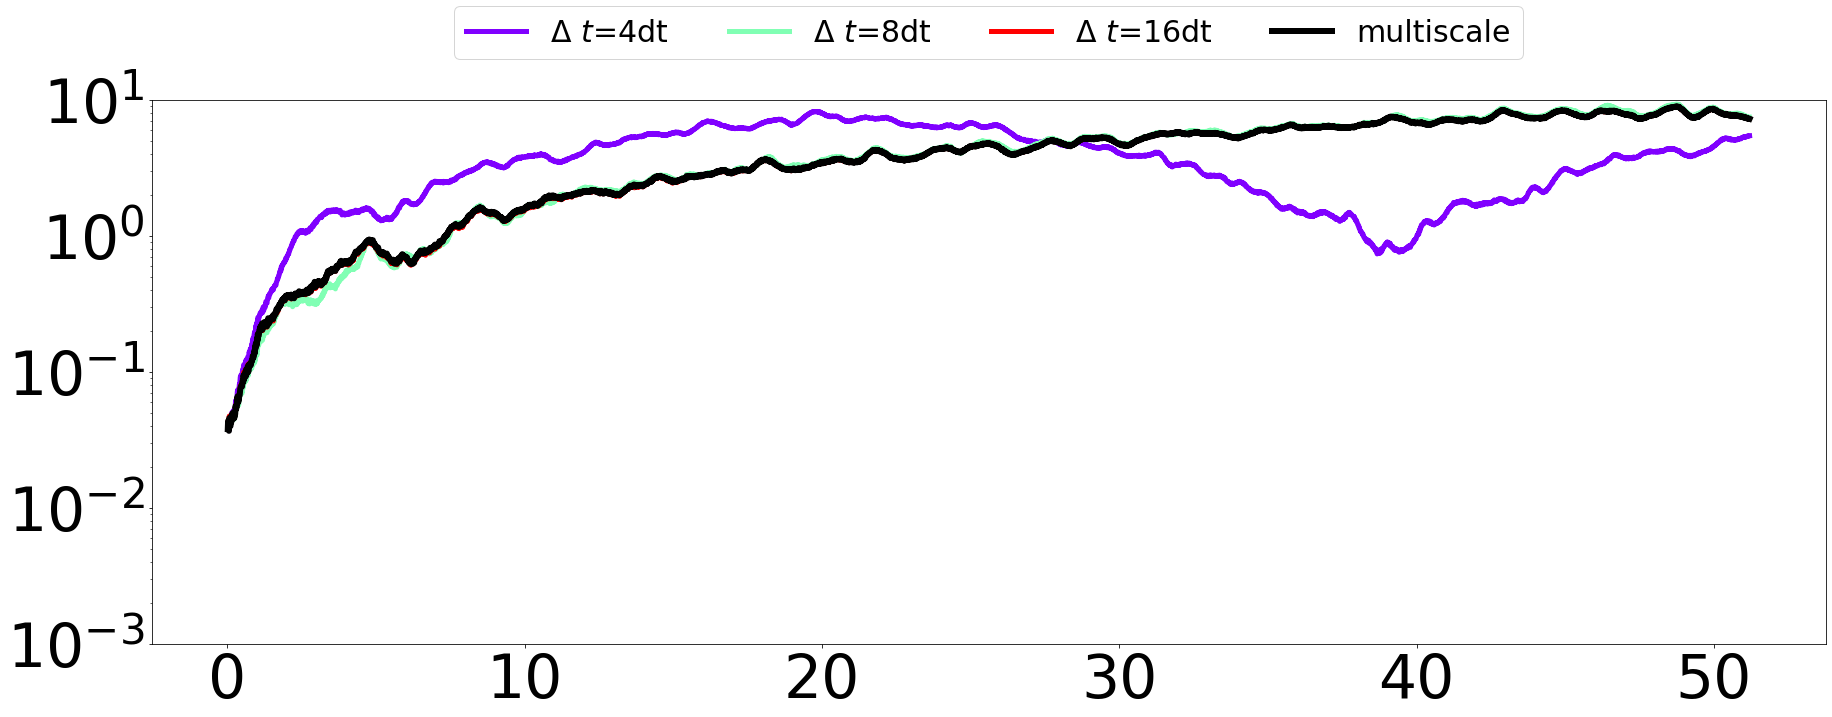

In [67]:
# multiscale time-stepping with NN
start = time.time()
# y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
y_preds = vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(preds_mse)):
    print(k)
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.semilogy(t, multiscale_err, linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

plt.ylim([0.001, 10])

In [68]:
torch.tensor(test_data[:, 0, :]).float().shape

torch.Size([320, 2])

(-3.0, 3.0)

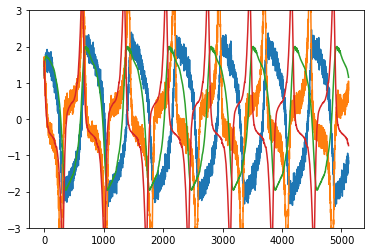

In [69]:
idx = 0
plt.plot(test_data[idx,1:,0])
plt.plot(test_data[idx,1:,1])
plt.plot(y_preds[idx,:,0])
plt.plot(y_preds[idx,:,1])
plt.ylim([-3,3])
# plt.show()

(-3.0, 3.0)

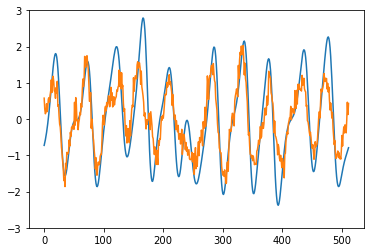

In [426]:
idx = 0
plt.plot(test_data[idx,10,:])
# plt.plot(y_preds[idx,:,0])
plt.plot(y_preds[idx,10,:])
plt.ylim([-3,3])
# plt.show()

Text(0.5, 1.0, 'Truth')

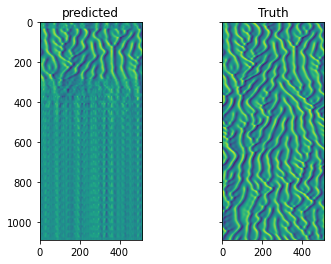

In [427]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(y_preds[idx], vmin = np.min(test_data[0]), vmax = np.max(test_data[0]))
ax1.set_title('predicted')
# plt.colorbar()
# plt.show()
ax2.imshow(test_data[idx], vmin = np.min(test_data[0]), vmax = np.max(test_data[0]))
ax2.set_title('Truth')
# plt.title("KS test point " + str(idx))
# ax2.colorbar()

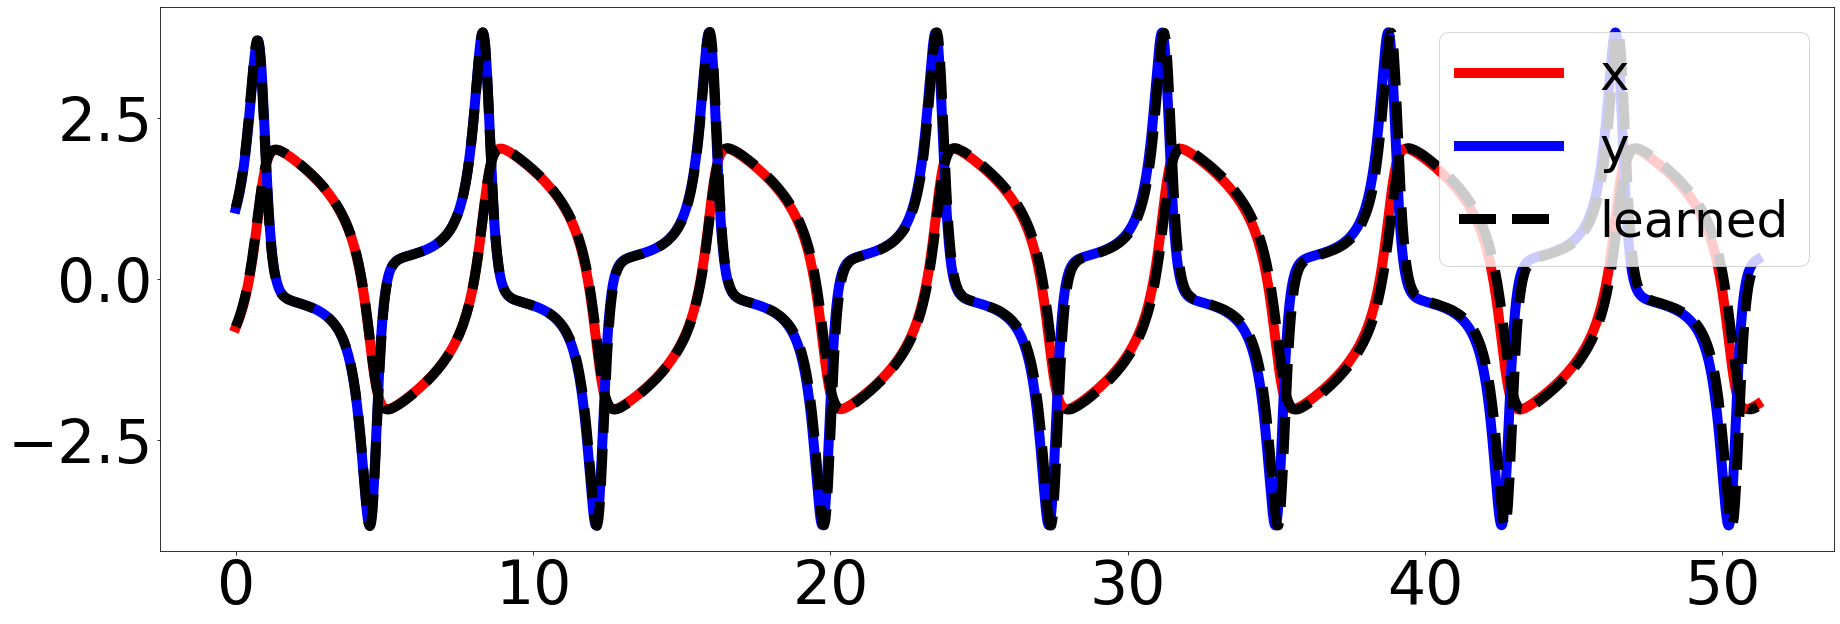

In [59]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 5
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, 0], 'r-', linewidth=10, label='x')
ax0.plot(t, test_data[idx, 0:n_steps, 1], 'b-', linewidth=10, label='y')
# ax0.plot(t, test_data[idx, 0:n_steps, 2], 'g-', linewidth=10, label='z')
ax0.plot(t, y_preds[idx, 0:n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='learned')
ax0.plot(t, y_preds[idx, 0:n_steps, 1].detach().numpy(), 'k--', linewidth=10)
# ax0.plot(t, y_preds[idx, 0:n_steps, 2].detach().numpy(), 'k--', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

In [60]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))

single scaled model (Dt=0.04): computing time 8.035000324249268s
single scaled model (Dt=0.08): computing time 4.736685037612915s
single scaled model (Dt=0.16): computing time 1.9905705451965332s
ensembled multiscale model: computing time 20.676104307174683s


In [70]:
import random
all_combos = np.load('all_combos_'+str(1)+'.npy', allow_pickle=True)
print(all_combos)
# all_combos = all_combos - 1

def predict_random_combo(models, test_data=test_data, timesteps = 5000, to_plot=True):

    models = models[1:]
    
    step_sizes = [8, 16]
    print("step_sizes= ", step_sizes)
    t = 0
    
#     idx_combo = random.sample(range(len(all_combos)), 1)
#     path = all_combos[idx_combo[0]]
#     print(path)
    
#     steps_per_combo = sum(path)

#     path_loops = timesteps // steps_per_combo - 1
    
#     print("path_loops = ", path_loops)
#     n_timepoints = path_loops * len(path)
#     print("n_steps = ", n_timepoints)
    
    n_test_points, _, ndim = test_data.shape


    t_list = list()
    y_pred_list = list()#np.zeros((n_test_points, n_timepoints, ndim))

    indices = np.random.randint(0,len(step_sizes), int(timesteps/min(step_sizes)))
#     print("indices = ", indices)
    steps = list()
    for i in range(len(indices)):# steps[-1] < timesteps:
        steps.append(step_sizes[indices[i]])
        if sum(steps)>timesteps:
            break
#     print(steps)
#     print("sum steps = ", sum(steps))
    
    y_pred_list = np.zeros((n_test_points, len(steps)-1, ndim))
#     this_step_size = path[0]
#     t+= this_step_size*4
#     y_preds = models[this_step_size-1].forward(torch.tensor(test_data[:, 0]).float())
    y_preds = torch.tensor(test_data[:, 0]).float()
#     y_pred_list[:,0] = y_preds.detach().numpy()
#     t_list[0] = t
#     print(y_preds.shape)

#     for j in range(n_timepoints-1):
    i = 1
#     while t < timesteps - max(step_sizes):
    for i in range(len(steps)-1):
        this_pick = indices[i]#np.random.randint(0,3)
        this_step_size = steps[i]#step_sizes[this_pick]#path[j%len(path)]
        t+= this_step_size
#         print("models[this_pick].forward(y_preds) shape = ", models[this_pick].forward(y_preds).shape)
        y_preds = models[this_pick].forward(y_preds)
        i +=1
#         print("y_preds.shape", y_preds.shape)

        y_pred_list[:,i-1] = y_preds.detach().numpy()
        t_list.append(t)
        
    t_list = np.array(t_list)
    y_pred_list = np.array(y_pred_list)
    
#     print("y_pred_list shape = ", y_pred_list.shape)
#     print("t_list= ", t_list)
#     print("test_data shape = ", test_data.shape)
#     print(" test_data[:,t_list.astype(int)] shape = ",  test_data[:,t_list.astype(int)].shape)
#     print("max t = ", max(t_list))
    if to_plot:
        plt.plot(t_list, y_pred_list[0,:,0])
        plt.plot(t_list, test_data[0,t_list.astype(int), 0])
        plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    mse = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    if to_plot:
        plt.semilogy(t_list, mse)
        plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    return y_pred_list, mse, t_list#, path

num_lines = 10
mse_list = list()
t_list_list = list()
path_list = list()
y_pred_list = list()

for i in range(num_lines):
    y_preds_random, mse_random, t_list_random = predict_random_combo(models, to_plot = False,  timesteps = 5000)#timesteps-(smallest_step*4))
    y_pred_list.append(y_preds_random[0,:])
    mse_list.append(mse_random)
    t_list_list.append(t_list_random)
#     path_list.append(path_random)

[(1, 1) (2,) (1, 1, 1) ... (4, 4, 2, 4, 1) (4, 4, 4, 1, 2) (4, 4, 4, 2, 1)]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]


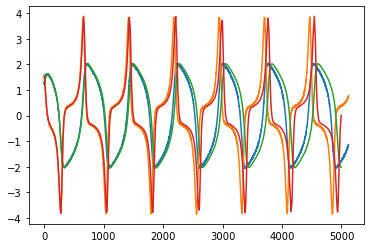

In [31]:
plt.plot(test_data[0, 1:])
plt.plot(t_list_random, y_preds_random[0])


[(1, 1) (2,) (1, 1, 1) ... (4, 4, 2, 4, 1) (4, 4, 4, 1, 2) (4, 4, 4, 2, 1)]
step_sizes=  [4, 8, 16]
y_pred_list shape =  (320, 100, 2)
t_list =  (100,)


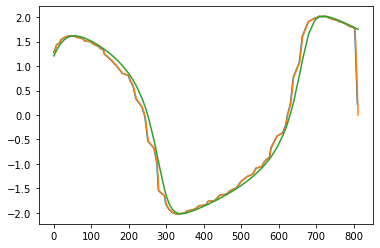

step_sizes=  [4, 8, 16]
y_pred_list shape =  (320, 100, 2)
t_list =  (100,)


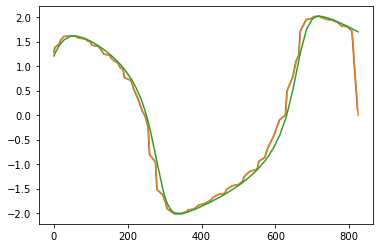

step_sizes=  [4, 8, 16]


KeyboardInterrupt: 

In [25]:
# import random
# all_combos = np.load('all_combos_'+str(1)+'.npy', allow_pickle=True)
# print(all_combos)
# # all_combos = all_combos - 1

# def predict_random_combo_fill(models, test_data=test_data, timesteps = 5000, to_plot=True):

#     print("step_sizes= ", step_sizes)
#     t = 0
    
#     n_test_points, _, ndim = test_data.shape


#     t_list = [0]
#     y_pred_list = list()#np.zeros((n_test_points, n_timepoints, ndim))

#     indices = np.random.randint(0,3, 100)
#     steps = list()
#     for i in range(100):# steps[-1] < timesteps:
#         steps.append(step_sizes[indices[i]])
#         if sum(steps)>timesteps:
#             break
# #     print("steps = step")
    
#     y_pred_list = np.zeros((n_test_points, len(steps), ndim))
#     y_preds = torch.tensor(test_data[:, 0]).float()
#     y_pred_list[:,0] = y_preds
#     for i in range(len(steps)-1):
#         this_pick = indices[i]#np.random.randint(0,3)
#         this_step_size = steps[i]#step_sizes[this_pick]#path[j%len(path)]
#         t+= this_step_size
# #         print("models[this_pick].forward(y_preds) shape = ", models[this_pick].forward(y_preds).shape)
#         y_preds = models[this_pick].forward(y_preds)
#         i +=1
# #         print("y_preds.shape", y_preds.shape)

#         y_pred_list[:,i-1] = y_preds.detach().numpy()
#         t_list.append(t)
        
#     t_list = np.array(t_list)
#     y_pred_list = np.array(y_pred_list)
    
#     # interpolations
#     sample_steps = range(1, max(t_list))
#     valid_preds = y_preds[:, :].detach().numpy()
#     print("y_pred_list shape = ", y_pred_list.shape)
#     print("t_list = ", t_list.shape)
#     cs = scipy.interpolate.interp1d(t_list, y_pred_list, kind='linear', axis=1)
#     y_preds_inter = torch.tensor(cs(sample_steps)).float()
# #     print(y_preds_inter)
    
#     plt.plot(y_preds_inter[0,:,0])
#     plt.plot(t_list, y_pred_list[0,:,0])
#     plt.plot(t_list, test_data[0,t_list.astype(int), 0])
#     plt.show()
    
#     if to_plot:
#         plt.plot(t_list, y_pred_list[0,:,0])
#         plt.plot(t_list, test_data[0,t_list.astype(int), 0])
#         plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
#         plt.show()
    
#     mse = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
#     if to_plot:
#         plt.semilogy(t_list, mse)
#         plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
#         plt.show()
    
#     return y_pred_list, mse, t_list#, path

# num_lines = 50
# mse_list = list()
# t_list_list = list()
# path_list = list()
# y_pred_list = list()

# for i in range(num_lines):
#     y_preds_random, mse_random, t_list_random = predict_random_combo_fill(models, to_plot = False,  timesteps = 1000)#timesteps-(smallest_step*4))
#     y_pred_list.append(y_preds_random[0,:])
#     mse_list.append(mse_random)
#     t_list_list.append(t_list_random)
# #     path_list.append(path_random)

0
1
2


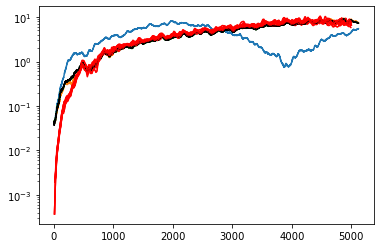

In [83]:
for k in range(len(preds_mse)):
    print(k)
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     rgb = next(colors)
    plt.semilogy(mean, linestyle='-')#, color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    
for i in range(len(mse_list)):
    plt.semilogy(t_list_list[i], mse_list[i], 'r')
#     print(t_list_list[i])
plt.semilogy(multiscale_err, 'k')

for i in range(len(mse_list)):
    plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5)#, label = path_list[i])

plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5, label="random")



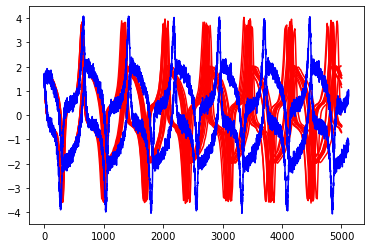

(3000.0, 5121.0)

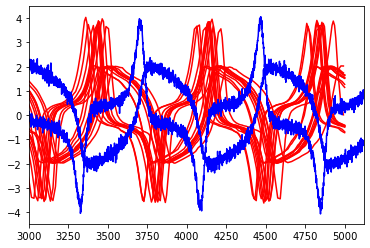

In [74]:
for i in range(len(y_pred_list)):
#     print(y_pred_list[i])
    plt.plot(t_list_list[i], y_pred_list[i], 'r')
#     plt.plot()
plt.plot(test_data[0,1:], 'b')

plt.show()
for i in range(len(y_pred_list)):
#     print(y_pred_list[i])
    plt.plot(t_list_list[i], y_pred_list[i], 'r')
#     plt.plot()
plt.plot(test_data[0,1:], 'b')
plt.xlim([3000, test_data.shape[1]])

# plt.xlim([4000,5000])

step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]
step_sizes=  [8, 16]


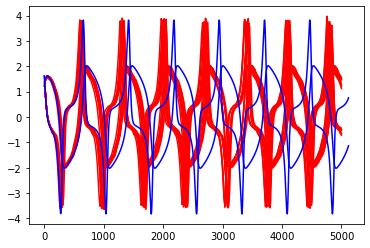

(3000.0, 5121.0)

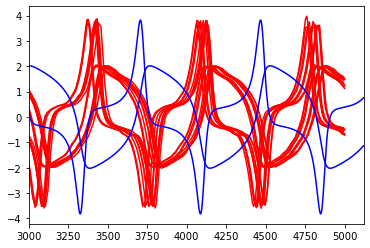

In [78]:
num_lines = 10
mse_list = list()
t_list_list = list()
path_list = list()
y_pred_list = list()

for i in range(num_lines):
    y_preds_random, mse_random, t_list_random = predict_random_combo(models, perfect_data, to_plot = False,  timesteps = 5000)#timesteps-(smallest_step*4))
    y_pred_list.append(y_preds_random[0,:])
    mse_list.append(mse_random)
    t_list_list.append(t_list_random)
    
for i in range(len(y_pred_list)):
#     print(y_pred_list[i])
    plt.plot(t_list_list[i], y_pred_list[i], 'r')
#     plt.plot()
plt.plot(perfect_data[0,1:], 'b')

plt.show()
for i in range(len(y_pred_list)):
#     print(y_pred_list[i])
    plt.plot(t_list_list[i], y_pred_list[i], 'r')
#     plt.plot()
plt.plot(perfect_data[0,1:], 'b')
plt.xlim([3000, test_data.shape[1]])

# plt.xlim([4000,5000])

0
1
2
(10, 10000, 2)


/tmp/ipykernel_819/1855918201.py:11: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)


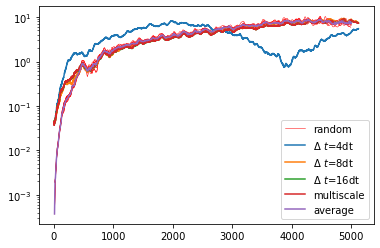

In [86]:
def find_ave_random_paths(t_list_list, mse_list):
    to_ave = np.zeros((num_lines, 10000, test_data.shape[-1]))
    print(to_ave.shape)

    for i in range(num_lines):
        for j in range(len(t_list_list[i])):
            to_ave[i, t_list_list[i][j]] = mse_list[i][j]

    averages = np.zeros(10000)
    to_ave[to_ave == 0] = np.nan
    means = np.nanmean(to_ave[:, 1:], axis=0)

    mask = np.isfinite(means[:,0])
    ts = np.arange(1, 10000)
    
    return ts[mask], means[mask]

plt.figure()
for i in range(len(mse_list)):
    plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5)#, label = path_list[i])

plt.semilogy(t_list_list[i], mse_list[i], 'r', linewidth = 0.5, label="random")


for k in range(len(preds_mse)):
    print(k)
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     rgb = next(colors)
    plt.semilogy(mean, label='$\Delta\ t$={}dt'.format(step_sizes[k]))#, color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    
plt.semilogy(multiscale_err, label = "multiscale")

ts, means = find_ave_random_paths(t_list_list, mse_list)
plt.plot(ts, means[:,0],  label = "average")


plt.legend()
plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths, original")
plt.savefig("{}_MSE_n{}_all_original.pdf".format(system, noise))

(10, 10000, 2)
(625,)
(625, 2)


/tmp/ipykernel_819/3185717435.py:11: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)


Text(0.5, 1.0, 'VanDerPol: mse for both methods using original stepper and random')

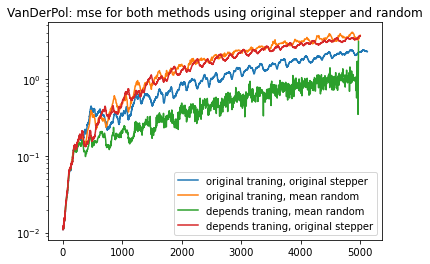

In [52]:
ts_high = np.load("ts_vbp.npy")
means_high = np.load("means_vdp.npy")
mse_high = np.load("mse_high_vdp.npy")

t_cloud = np.load("t_cloud.npy", allow_pickle=True)
mse_cloud = np.load("mse_cloud.npy", allow_pickle=True)

# for i in range(len(mse_cloud)):
#     plt.semilogy(t_cloud[i], mse_cloud[i], 'r', linewidth = 0.5)#, label = path_list[i])

plt.semilogy(multiscale_err, label = "original traning, original stepper")

ts, means = find_ave_random_paths(t_list_list, mse_list)
print(ts.shape)
print(means.shape)
plt.semilogy(ts, means[:,1], label = "original traning, mean random")#, linestyle='-', marker='o')
# plt.semilogy(means[:,0])

plt.plot(ts_high, means_high[:,1], label  = "depends traning, mean random")
plt.plot(mse_high, label  = "depends traning, original stepper")

# for i in range(len(mse_list)):
#     plt.semilogy(t_list_list[i], mse_list[i], 'b')
    
# plt.plot(ts, means[:,1], 'g', label = "original traning, mean random")
plt.legend()

plt.title(system + ": mse for both methods using original stepper and random")

Text(0.5, 1.0, 'VanDerPol: mse of random paths with average')

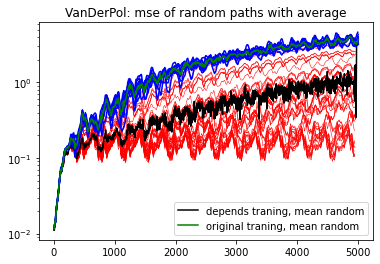

In [53]:
ts_high = np.load("ts_vbp.npy")
means_high = np.load("means_vdp.npy")
mse_high = np.load("mse_high_vdp.npy")

t_cloud = np.load("t_cloud.npy", allow_pickle=True)
mse_cloud = np.load("mse_cloud.npy", allow_pickle=True)

for i in range(len(mse_cloud)):
    plt.semilogy(t_cloud[i], mse_cloud[i], 'r', linewidth = 0.5)#, label = path_list[i])

# plt.semilogy(multiscale_err, label = "original traning, original stepper")

# ts, means = find_ave_random_paths(t_list_list, mse_list)
# print(ts.shape)
# print(means.shape)
# plt.plot(ts, means[:,1], label = "original traning, mean random")#, linestyle='-', marker='o')
# # plt.semilogy(means[:,0])

plt.plot(ts_high, means_high[:,1], 'k', label  = "depends traning, mean random")
# plt.plot(mse_high, label  = "depends traning, original stepper")

for i in range(len(mse_list)):
    plt.semilogy(t_list_list[i], mse_list[i], 'b')
    
plt.plot(ts, means[:,1], 'g', label = "original traning, mean random")
plt.legend()

plt.title(system + ": mse of random paths with average")

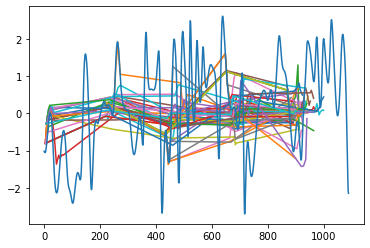

In [398]:
for i in range(len(y_pred_list)):
    plt.plot(t_list_list[i], y_pred_list[i][:,0])
    
plt.plot(test_data[0,:,0])

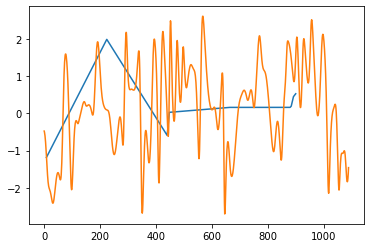

In [378]:
i = 1
plt.plot(t_list_random, y_preds_random[i, : ,0])
plt.plot(test_data[i, : ,0])
plt.show()

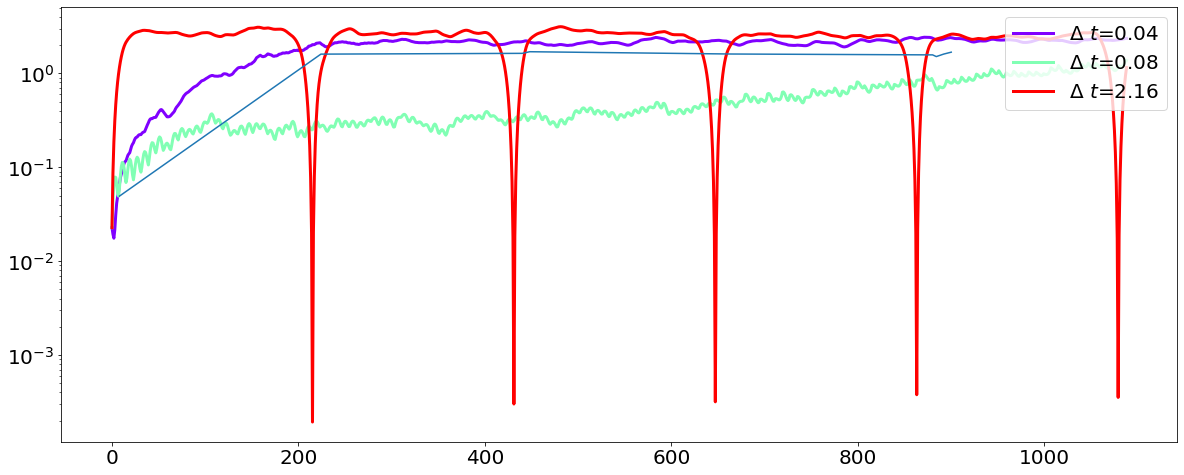

In [374]:
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.semilogy(t_list_list[0],mse_list[0])
plt.show()

In [46]:
len(mse_list)

1